In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
Guangzhou = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/GuangzhouPM20100101_20151231.csv")


In [3]:
Guangzhou.dropna(axis=0, how="any",inplace=True)

In [4]:
# from datetime import datetime
Guangzhou['Time'] = pd.to_datetime(Guangzhou['year'].map(str) +"/"+ Guangzhou['month'].map(str) +"/"+ Guangzhou['day'].map(str)+" "+Guangzhou['hour'].map(str)+":00:00")
#Beijing

In [5]:
by_hour = Guangzhou.groupby(['Time']).mean()
by_hour.head()

,No,year,month,day,hour,season,PM_City Station,PM_5th Middle School,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
Time,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,1,1,0,4.0,83.0,78.0,83.0,3.7,91.0,1014.2,5.0,1.9,0.0,0.0
2013-01-01 01:00:00,26306,2013,1,1,1,4.0,95.0,70.0,95.0,4.2,88.0,1014.2,6.0,3.4,0.0,0.0
2013-01-01 03:00:00,26308,2013,1,1,3,4.0,55.0,66.0,55.0,3.5,76.0,1013.9,7.5,5.8,0.0,0.0
2013-01-01 04:00:00,26309,2013,1,1,4,4.0,60.0,69.0,60.0,2.7,69.0,1013.9,8.0,8.2,0.0,0.0
2013-01-01 05:00:00,26310,2013,1,1,5,4.0,41.0,51.0,41.0,1.5,62.0,1014.2,8.4,9.0,0.0,0.0


In [6]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2015-12-31 13:00:00', '2015-12-31 14:00:00',
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Time', length=26279, freq='H')


In [7]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2013-01-01 00:00:00   2013-01-01 00:00:00
2013-01-01 01:00:00   2013-01-01 01:00:00
2013-01-01 02:00:00   2013-01-01 02:00:00
2013-01-01 03:00:00   2013-01-01 03:00:00
2013-01-01 04:00:00   2013-01-01 04:00:00
                              ...        
2015-12-31 18:00:00   2015-12-31 18:00:00
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
Freq: H, Name: Time, Length: 26279, dtype: datetime64[ns]

In [8]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20150101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [9]:
data_13 = data_13.set_index(data_13.index).asfreq('H')

In [10]:
#########################################################################################################

In [11]:
#Creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data_13, label='PM_US Post')

features_and_target = pd.concat([X, y], axis=1)

In [12]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PM_US Post
Time,,,,,,,,,
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1,34.0
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1,42.0
2015-01-01 05:00:00,5,3,1,1,2015,1,1,1,44.0
2015-01-01 06:00:00,6,3,1,1,2015,1,1,1,48.0
2015-01-01 07:00:00,7,3,1,1,2015,1,1,1,50.0


In [13]:
###############################################################################################################

In [14]:
#Plotting the Features to see trends

##Power demand has strong daily and seasonal properties.
##Day of week also seems to show differences in peaks.

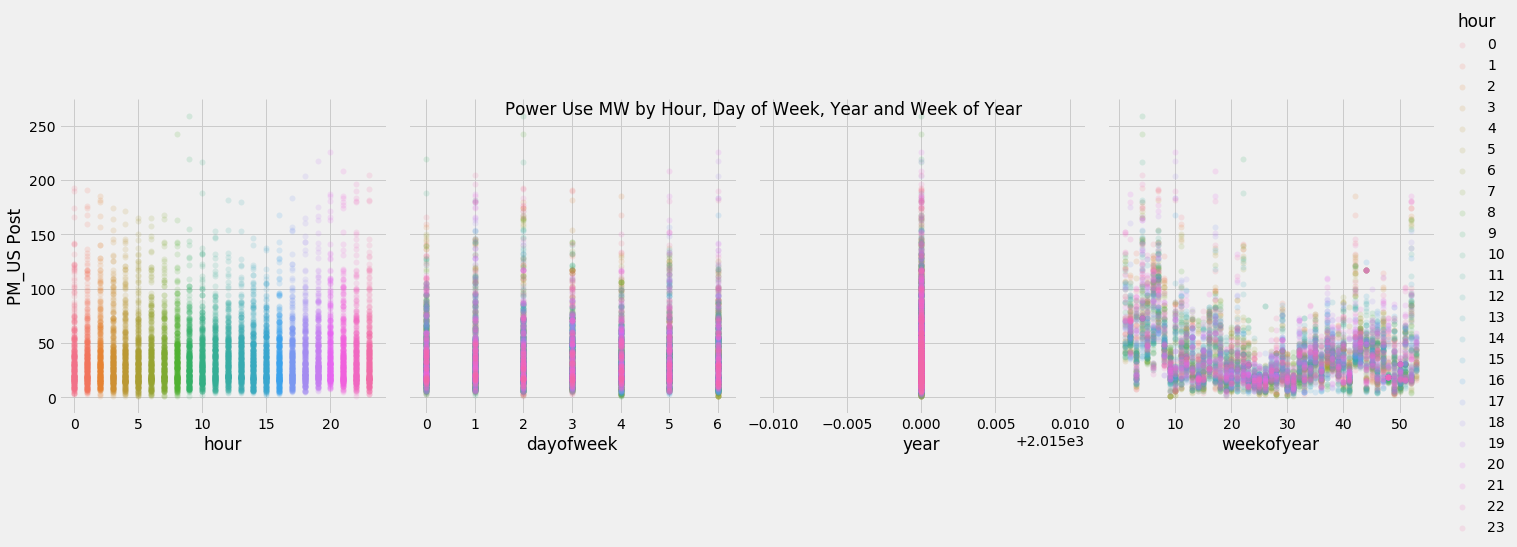

In [15]:
 sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PM_US Post',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [16]:
###############################################################################################################

In [17]:
#Train/Test Split
##Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [18]:
split_date = '2015-10-01 03:00:00'
data_13_train = data_13.loc[data_13.index <= split_date].copy()
data_13_test = data_13.loc[data_13.index > split_date].copy()

In [19]:
###############################################################################################################

In [20]:
# Format data for prophet model using ds and y
## Use parameter drop=True which not create new column with index but remove it

data_13_train.reset_index(drop=True) \
    .rename(columns={'Time':'ds',
                     'PM_US Post':'y'}).head()

,No,year,month,day,hour,season,PM_City Station,PM_5th Middle School,y,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,ds
0,43828.0,2015.0,1.0,1.0,3.0,4.0,34.0,34.0,34.0,2.0,50.0,1015.4,12.1,26.2,0.0,0.0,2015-01-01 03:00:00
1,43829.0,2015.0,1.0,1.0,4.0,4.0,42.0,41.0,42.0,1.8,47.0,1015.5,12.9,2.1,0.0,0.0,2015-01-01 04:00:00
2,43830.0,2015.0,1.0,1.0,5.0,4.0,44.0,41.0,44.0,2.8,58.0,1015.7,10.8,3.1,0.0,0.0,2015-01-01 05:00:00
3,43831.0,2015.0,1.0,1.0,6.0,4.0,48.0,51.0,48.0,2.3,55.0,1016.3,11.0,3.6,0.0,0.0,2015-01-01 06:00:00
4,43832.0,2015.0,1.0,1.0,7.0,4.0,50.0,47.0,50.0,2.1,56.0,1017.1,10.6,5.5,0.0,0.0,2015-01-01 07:00:00


In [21]:
# Setup and train model and fit
model = Prophet()
model.fit(data_13_train.reset_index(drop=True) \
              .rename(columns={'Time':'ds',
                               'PM_US Post':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
# Predict on training set with model
df_test_fcst = model.predict(df=data_13_test.reset_index(drop=True) \
                                   .rename(columns={'Time':'ds'}))

In [23]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-01 04:00:00,42.744521,9.286727,68.177782,42.744521,42.744521,-3.873358,-3.873358,-3.873358,-0.870991,-0.870991,-0.870991,-3.002367,-3.002367,-3.002367,0.0,0.0,0.0,38.871163
1,2015-10-01 05:00:00,42.756176,7.744601,67.435470,42.756176,42.756176,-4.540781,-4.540781,-4.540781,-1.428875,-1.428875,-1.428875,-3.111906,-3.111906,-3.111906,0.0,0.0,0.0,38.215395
2,2015-10-01 06:00:00,42.767830,8.325924,67.418023,42.767830,42.767830,-4.837474,-4.837474,-4.837474,-1.620962,-1.620962,-1.620962,-3.216511,-3.216511,-3.216511,0.0,0.0,0.0,37.930357
3,2015-10-01 07:00:00,42.779485,5.902922,68.299292,42.779485,42.779485,-4.775823,-4.775823,-4.775823,-1.460090,-1.460090,-1.460090,-3.315733,-3.315733,-3.315733,0.0,0.0,0.0,38.003662
4,2015-10-01 08:00:00,42.791140,6.995478,70.104344,42.791140,42.791140,-4.588572,-4.588572,-4.588572,-1.179400,-1.179400,-1.179400,-3.409171,-3.409171,-3.409171,0.0,0.0,0.0,38.202568


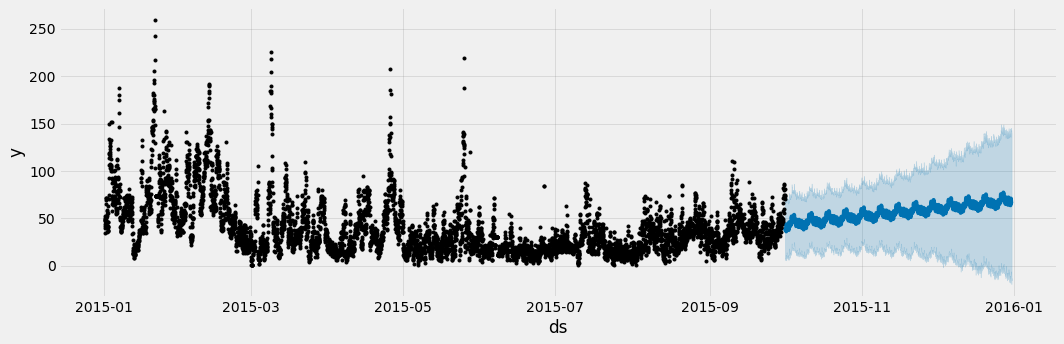

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

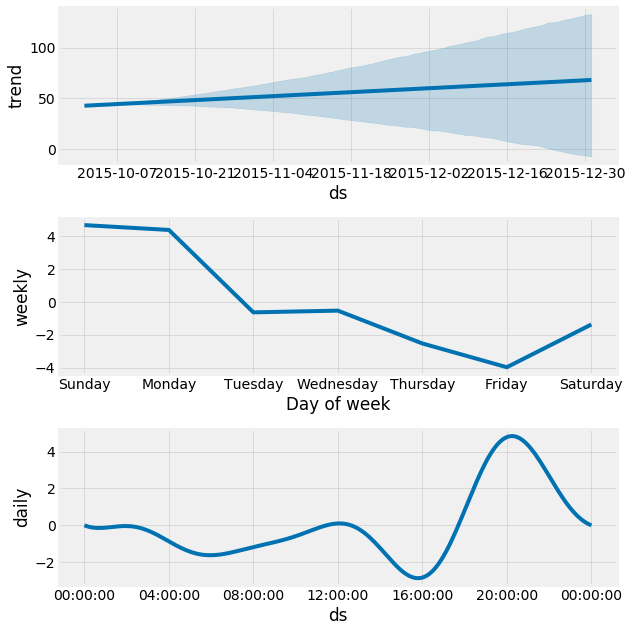

In [25]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

In [26]:
###############################################################################################################

In [27]:
#Compare Forecast to Actuals

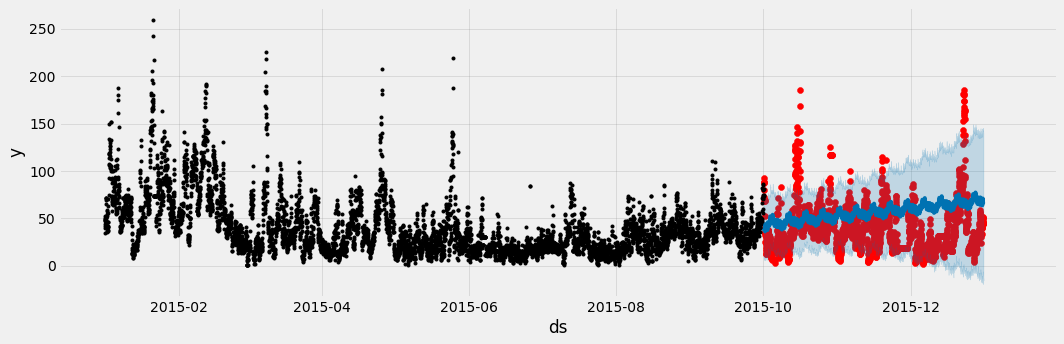

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

In [29]:
#Look at first month of predictions

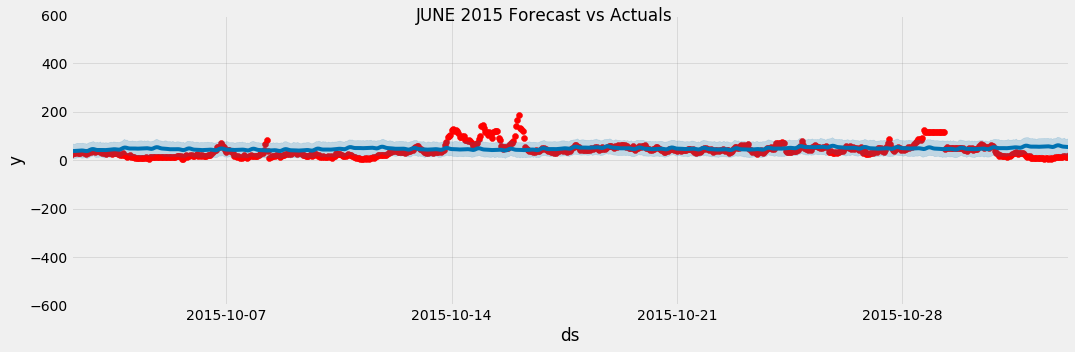

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20151002040000'),
              upper=pd.to_datetime('20151102040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('JUNE 2015 Forecast vs Actuals')

In [31]:
###############################################################################################################

In [32]:
#Single Week of Predictions

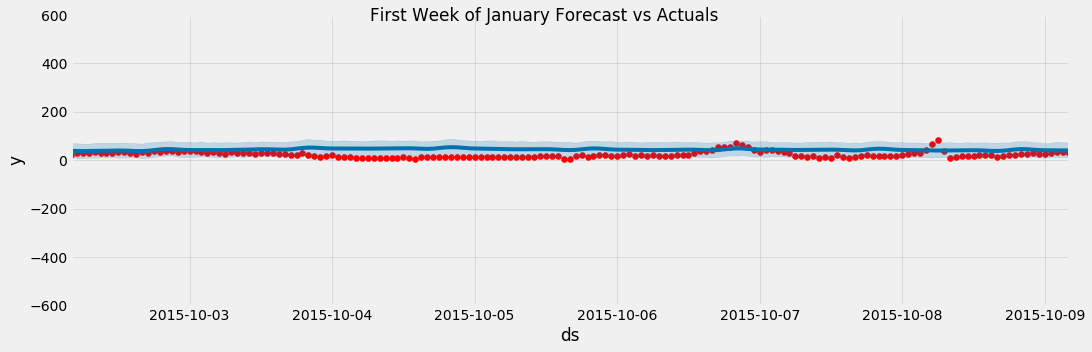

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_13_test.index, data_13_test['PM_US Post'], color='r')
fig = model.plot(df_test_fcst , ax=ax)

ax.set_xbound(lower=pd.to_datetime('20151002040000'),
              upper=pd.to_datetime('20151009040000'))
ax.set_ylim(-600, 600)
plot = plt.suptitle('First Week of January Forecast vs Actuals')